In [22]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
# Carregar os dados
data = pd.read_csv(r'C:\Users\z004hn4c\Documents\Pump_Project\marine_engine_data.csv')

# Remover colunas existentes de falha e manutenção
data = data.drop(columns=['failure_mode', 'maintenance_status'])

# Definir thresholds baseados nas estatísticas do dataset
thresholds = {
    'engine_temp_overheating': 95,
    'oil_pressure_low': 6,
    'fuel_consumption_high': 1.5 * data['fuel_consumption'].median(),  # 5187 L/h
    'vibration_level_high': 4.5,
    'rpm_low': 1200,
    'rpm_high': 1800,
    'engine_load_high': 70,
    'coolant_temp_high': 95,
    'exhaust_temp_high': 450,
    'running_period_long': 150,
    'fuel_consumption_per_hour_high': 1.2 * data['fuel_consumption_per_hour'].median()  # 120 L/h
}

# Criar condições de falha
data['overheating'] = (
    (data['engine_temp'] > thresholds['engine_temp_overheating']) |
    (data['coolant_temp'] > thresholds['coolant_temp_high']) |
    (data['exhaust_temp'] > thresholds['exhaust_temp_high'])
).astype(int)

data['oil_leakage'] = (data['oil_pressure'] < thresholds['oil_pressure_low']).astype(int)

data['mechanical_wear'] = (
    (data['vibration_level'] > thresholds['vibration_level_high']) |
    (data['running_period'] > thresholds['running_period_long']) |
    (data['rpm'] < thresholds['rpm_low']) |
    (data['rpm'] > thresholds['rpm_high'])
).astype(int)

data['fuel_issues'] = (
    (data['fuel_consumption'] > thresholds['fuel_consumption_high']) |
    (data['fuel_consumption_per_hour'] > thresholds['fuel_consumption_per_hour_high'])
).astype(int)

# Combinar condições para criar a coluna 'failure_mode'
conditions = [
    data['overheating'] == 1,
    data['oil_leakage'] == 1,
    data['mechanical_wear'] == 1,
    data['fuel_issues'] == 1
]

choices = [
    'Overheating',
    'Oil Leakage',
    'Mechanical Wear',
    'Fuel Issues'
]

data['failure_mode'] = np.select(conditions, choices, default='No Failure')

# Mapeamento de severidade
failure_mode_to_severity = {
    'No Failure': 'Normal',
    'Oil Leakage': 'Requires Maintenance',
    'Mechanical Wear': 'Critical',
    'Overheating': 'Critical',
    'Fuel Issues': 'Requires Maintenance'
}

# Adicionar a coluna 'severity' ao dataset
data['severity'] = data['failure_mode'].map(failure_mode_to_severity)

# Verificar a distribuição de severidades
print(data['severity'].value_counts())

# Remover colunas intermediárias
data = data.drop(columns=['overheating', 'oil_leakage', 'mechanical_wear', 'fuel_issues'])

# Exibir resultados
display(data['failure_mode'].value_counts())

severity
Normal                  2165
Critical                1686
Requires Maintenance    1349
Name: count, dtype: int64


failure_mode
No Failure         2165
Mechanical Wear    1042
Fuel Issues         971
Overheating         644
Oil Leakage         378
Name: count, dtype: int64

In [24]:
data.describe()

,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,85.067979,7.281496,3937.674530,3.746574,1496.909900,49.794979,85.000245,449.829456,84.045362,116.270048
std,7.244281,0.750153,2439.427599,0.366415,202.952635,17.366150,7.475177,1.302990,48.932473,82.219935
min,60.524875,5.000000,1000.000000,2.500000,732.668890,20.000698,70.000000,426.124325,0.026501,100.000000
25%,79.895619,6.723802,1880.183832,3.500402,1362.119419,34.631768,79.567776,450.000000,41.128329,100.000000
50%,85.043649,7.484437,3458.765539,3.744904,1496.020797,49.965640,84.999981,450.000000,84.034658,100.000000
75%,90.284900,8.000000,5579.230554,3.994230,1635.905091,64.850333,90.397305,450.000000,127.258907,100.000000
max,107.357690,8.000000,12672.543097,5.000000,2205.811038,79.983060,100.000000,450.000000,167.987371,800.000000


In [25]:
# Aplicar One-Hot Encoding na coluna 'failure_mode'
data_encoded = pd.get_dummies(data, columns=['failure_mode'], drop_first=False)

# Exibir as primeiras linhas do dataset codificado
display(data_encoded.head())

,timestamp,engine_id,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,...,fuel_consumption_per_hour,engine_type,fuel_type,manufacturer,severity,failure_mode_Fuel Issues,failure_mode_Mechanical Wear,failure_mode_No Failure,failure_mode_Oil Leakage,failure_mode_Overheating
0,2023-01-01,ENG_001,79.816406,7.049409,1000.000000,4.366612,1770.214578,42.472407,78.323108,450.0,...,100.0,4-stroke High-Speed,Diesel,MAN B&W,Normal,False,False,True,False,False
1,2023-01-08,ENG_001,98.982068,8.000000,6308.623817,3.732792,1677.238238,77.042858,100.000000,450.0,...,100.0,2-stroke Low-Speed,Diesel,Mitsubishi,Critical,False,False,False,False,True
2,2023-01-15,ENG_001,83.918153,8.000000,6444.402260,4.061372,1487.472085,63.919637,78.178337,450.0,...,100.0,2-stroke Medium-Speed,Diesel,Caterpillar,Requires Maintenance,True,False,False,False,False
3,2023-01-22,ENG_001,81.887081,7.601603,4439.946613,3.999554,1548.624692,55.919509,82.896344,450.0,...,100.0,2-stroke Medium-Speed,Diesel,MAN B&W,Normal,False,False,True,False,False
4,2023-01-29,ENG_001,78.550429,6.233033,3146.234038,4.520559,1441.151499,29.361118,80.791150,450.0,...,100.0,4-stroke High-Speed,Diesel,Wärtsilä,Critical,False,True,False,False,False


In [26]:
# Selecionar colunas numéricas e de falha
numeric_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns
failure_columns = [col for col in data_encoded.columns if col.startswith('failure_mode_')]

# Criar um DataFrame apenas com as colunas de interesse
data_corr = data_encoded[numeric_columns.tolist() + failure_columns]

In [27]:
# Calcular a matriz de correlação de Spearman
correlation_matrix = data_corr.corr(method='spearman')

# Exibir a matriz de correlação
display(correlation_matrix)

,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour,failure_mode_Fuel Issues,failure_mode_Mechanical Wear,failure_mode_No Failure,failure_mode_Oil Leakage,failure_mode_Overheating
engine_temp,1.000000,0.635278,0.330796,0.335419,0.008333,0.726800,0.921801,0.244246,0.014427,0.025719,0.091565,-0.061486,-0.239998,-0.283497,0.548993
oil_pressure,0.635278,1.000000,0.389956,0.415052,0.019061,0.864014,0.586121,0.158940,0.016064,0.036904,0.203426,0.014791,-0.160344,-0.457602,0.341995
fuel_consumption,0.330796,0.389956,1.000000,0.194920,0.007634,0.440610,0.301481,0.106724,0.774912,-0.324284,0.252432,0.197633,-0.372621,-0.190346,0.168856
vibration_level,0.335419,0.415052,0.194920,1.000000,0.261680,0.475095,0.307349,0.081338,-0.017425,0.031935,0.093729,0.028011,-0.109958,-0.186654,0.166745
rpm,0.008333,0.019061,0.007634,0.261680,1.000000,0.015954,0.010388,0.004789,0.000557,0.027992,0.012548,0.003186,-0.003301,-0.028035,0.008321
engine_load,0.726800,0.864014,0.440610,0.475095,0.015954,1.000000,0.671970,0.181203,0.008311,0.034670,0.216616,-0.004770,-0.232368,-0.384619,0.400419
coolant_temp,0.921801,0.586121,0.301481,0.307349,0.010388,0.671970,1.000000,0.228545,0.007553,0.029351,0.069837,-0.070175,-0.234811,-0.263449,0.561693
exhaust_temp,0.244246,0.158940,0.106724,0.081338,0.004789,0.181203,0.228545,1.000000,0.022968,-0.013011,0.043119,0.008995,-0.044829,-0.078724,0.067192
running_period,0.014427,0.016064,0.774912,-0.017425,0.000557,0.008311,0.007553,0.022968,1.000000,-0.501206,0.038031,0.284045,-0.263244,-0.007637,0.009803
fuel_consumption_per_hour,0.025719,0.036904,-0.324284,0.031935,0.027992,0.034670,0.029351,-0.013011,-0.501206,1.000000,0.305088,-0.046429,-0.195499,-0.028629,0.010620


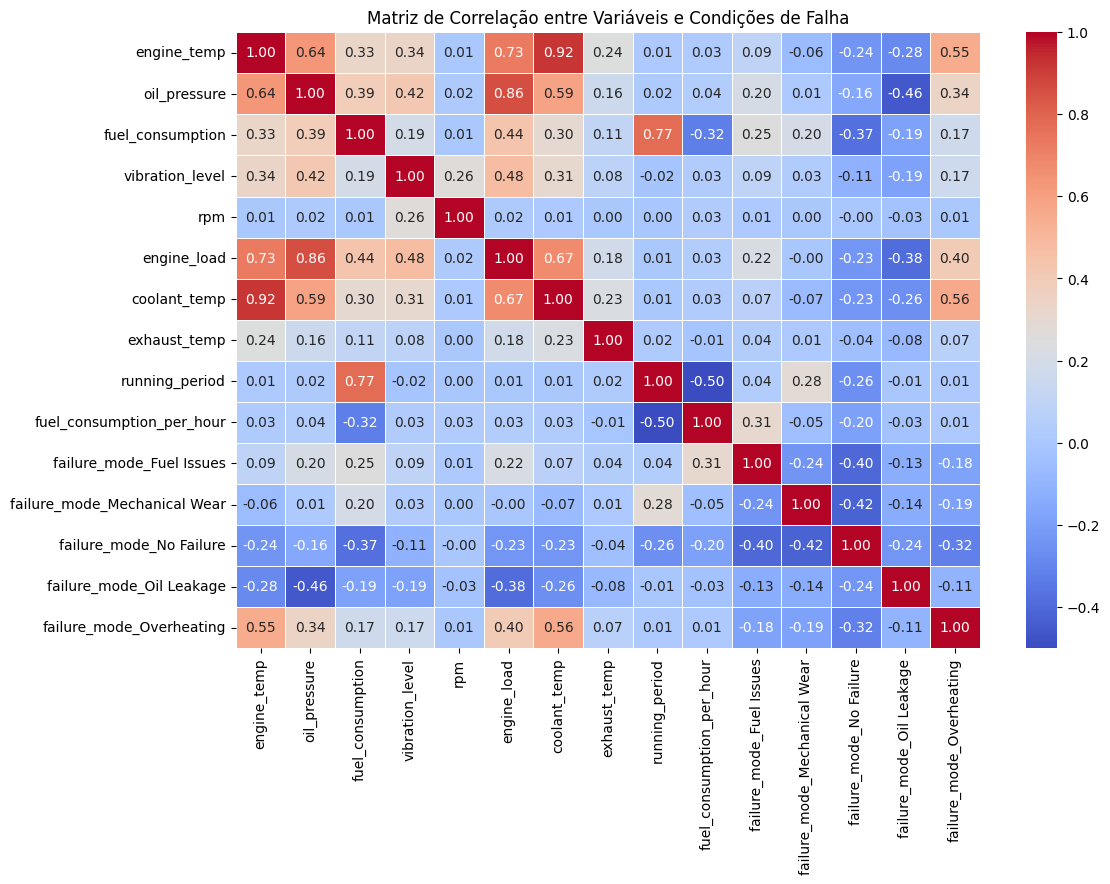

In [28]:
# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis e Condições de Falha')
plt.show()

In [30]:
data.to_csv("marine_engine_data_1.csv", index=None)